In [1]:
import sys
sys.path.append(r"C:\Users\trund\QRT")

from backtest.backtesting import Backtester, FunctionStrategy# To backtest the strategy
from backtest.backtest_results import VisualiseBacktestResults
import eda_package

from typing import Optional, List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import scipy.stats as stats
import yfinance as yf

## Usage Instructions

**For COVID Period Analysis:**

1. **Before COVID** 
   - `ANALYSIS_START = "2019-01-01"`
   - `ANALYSIS_END = "2020-03-01"` (right before lockdowns)

2. **During COVID**:
   - `ANALYSIS_START = "2020-03-01"`
   - `ANALYSIS_END = "2021-06-01"`

3. **Post-COVID**:
   - `ANALYSIS_START = "2021-06-01"`
   - `ANALYSIS_END = "2022-12-31"`

**Important:** 
- Always use `dataset_analysis` (not `dataset`) for backtesting to ensure proper date filtering
- The code automatically fetches 285 extra days before `ANALYSIS_START` to calculate the 200-day MA
- All moving averages will be valid from the start of your analysis period

In [2]:
# Updated function with date parameters instead of period
def generate_jd_dataset_with_dates(ticker, start_date, end_date, sma_windows, interval='1d') -> pd.DataFrame:
    """
    Generate dataset with technical indicators using specific date range.
    
    Parameters:
    -----------
    ticker : str
        Stock ticker symbol
    start_date : str
        Start date for data download (should be ~285 days before analysis start for 200-day MA)
    end_date : str
        End date for data download
    sma_windows : list
        List of SMA window periods [short, medium, long]
    interval : str
        Data interval: '1d' for daily (default), '1wk' for weekly, '1mo' for monthly
    """
    
    # 1. Download data using specific dates and interval
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval, auto_adjust=False)
    df = data.copy()

    # Flatten Multi-Index if necessary
    if isinstance(data.columns, pd.MultiIndex):
        # Change the columns to their names 
        df.columns = [f"{column[0]}" for column in df.columns]

    # Adjust names of columns before proceeding
    df.columns = [column.replace(" ", "_") for column in df.columns]

    calculated_with = "Adj_Close"

    # 2. Simple Moving Average (using Adjusted Close for better accuracy)
    for i in range(len(sma_windows)):
        df[f"SMA_{sma_windows[i]}"] = df[calculated_with].rolling(window=sma_windows[i]).mean()

    # 3. Momentum Signal (RSI)
    delta = df[calculated_with].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df[f'Momentum_RSI'] = 100 - (100 / (1 + rs))

    # 4. Log Returns (calculated on Adjusted Close)
    df[f'Log_Returns'] = np.log(df[calculated_with] / df[calculated_with].shift(1))

    # 5. Unusual Volume Logic
    vol_avg = df[f'Volume'].rolling(window=20).mean()
    vol_std = df[f'Volume'].rolling(window=20).std()
    df['Unusual_Volume'] = np.where(df[f'Volume'] > (vol_avg + 1.5 * vol_std), 1, 0)

    # Drop NaNs and reorder for clarity - verified that the only missing dates are from SMA
    df.columns = [f"{ticker}_{column}" for column in df.columns]
    df.dropna(inplace=True)

    # Technically this line is not needed 
    cols = [calculated_with, f'Volume', f"SMA_{sma_windows[0]}", f"SMA_{sma_windows[1]}", f"SMA_{sma_windows[2]}", f'Momentum_RSI', f'Log_Returns', 'Unusual_Volume']
    cols = [f"{ticker}_{column}" for column in cols]

    return df[cols].rename(columns={f"{ticker}_Adj_Close": ticker})

In [3]:
# Date configuration for COVID period analysis
from datetime import datetime, timedelta

# Define your actual analysis period (e.g., before COVID - March 2020)
ANALYSIS_START = "2023-01-01"  # Start of 2025 tumble
ANALYSIS_END = "2025-03-31"    # Q1 aftermath

# Calculate data fetch start date (200 trading days ≈ 285 calendar days to be safe)
analysis_start_dt = datetime.strptime(ANALYSIS_START, "%Y-%m-%d")
data_fetch_start = (analysis_start_dt - timedelta(days=285)).strftime("%Y-%m-%d")

print(f"Fetching data from: {data_fetch_start}")
print(f"Analysis period: {ANALYSIS_START} to {ANALYSIS_END}")
print(f"Extra days for 200-day MA warm-up: ~285 days")

Fetching data from: 2022-03-22
Analysis period: 2023-01-01 to 2025-03-31
Extra days for 200-day MA warm-up: ~285 days


In [4]:
# Generate dataset with date-based approach
tickers = ["NVDA", "TSLA", "AAPL", "AMZN", "MSFT", "META", "GOOGL"]
sma_windows = [2, 1, 28] 
datasets = []

print(f"Downloading data from {data_fetch_start} to {ANALYSIS_END}...")
print(f"This includes ~285 extra days for 200-day MA calculation\n")

for ticker in tickers:
    print(f"Downloading {ticker}...")
    datasets.append(generate_jd_dataset_with_dates(
        ticker=ticker, 
        start_date=data_fetch_start,  # Start earlier for MA warm-up
        end_date=ANALYSIS_END,        # End at your analysis cutoff
        sma_windows=sma_windows,
        interval="1wk"
    ))

dataset = pd.concat(datasets, axis=1)

# Filter to actual analysis period (remove warm-up period)
dataset_analysis = dataset.loc[ANALYSIS_START:ANALYSIS_END]

print(f"\n✓ Full dataset shape: {dataset.shape}")
print(f"✓ Analysis dataset shape: {dataset_analysis.shape}")
print(f"✓ Full date range: {dataset.index[0].strftime('%Y-%m-%d')} to {dataset.index[-1].strftime('%Y-%m-%d')}")
print(f"✓ Analysis date range: {dataset_analysis.index[0].strftime('%Y-%m-%d')} to {dataset_analysis.index[-1].strftime('%Y-%m-%d')}")

dataset_analysis

This includes ~285 extra days for 200-day MA calculation



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✓ Full dataset shape: (131, 56)
✓ Analysis dataset shape: (117, 56)
✓ Full date range: 2022-09-26 to 2025-03-24
✓ Analysis date range: 2023-01-02 to 2025-03-24


,NVDA,NVDA_Volume,NVDA_SMA_2,NVDA_SMA_1,NVDA_SMA_28,NVDA_Momentum_RSI,NVDA_Log_Returns,NVDA_Unusual_Volume,TSLA,TSLA_Volume,...,META_Log_Returns,META_Unusual_Volume,GOOGL,GOOGL_Volume,GOOGL_SMA_2,GOOGL_SMA_1,GOOGL_SMA_28,GOOGL_Momentum_RSI,GOOGL_Log_Returns,GOOGL_Unusual_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,14.844139,1626813000,14.721762,14.844139,15.200787,62.204485,0.016626,0,113.059998,790689200,...,0.077367,0,86.685028,131561900,87.126694,86.685028,101.566465,41.889514,-0.010139,0
2023-01-09,16.882101,2240313000,15.863120,16.882101,15.285846,68.373638,0.128649,0,122.400002,891852300,...,0.052146,0,91.429192,142921000,89.057110,91.429192,100.977434,43.808989,0.053284,0
2023-01-16,17.821159,1968625000,17.351630,17.821159,15.357551,75.010112,0.054133,0,133.419998,691307300,...,0.017297,0,97.284943,161910600,94.357067,97.284943,100.221237,51.286123,0.062079,0
2023-01-23,20.344633,2632581000,19.082896,20.344633,15.522090,77.226936,0.132431,0,177.899994,1095958300,...,0.085036,0,98.624817,179407400,97.954880,98.624817,99.781436,48.356375,0.013679,0
2023-01-30,21.078899,2640747000,20.711766,21.078899,15.657332,76.188874,0.035455,0,189.979996,1091608900,...,0.206424,0,103.994247,227821100,101.309532,103.994247,99.670843,57.845126,0.053013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24,124.885834,1677630500,129.639534,124.885834,132.448607,41.210338,-0.073370,0,292.980011,527844600,...,-0.022712,0,169.615707,195320500,174.287415,169.615707,175.346136,53.799223,-0.053622,0
2025-03-03,112.659187,1756820000,118.772511,112.659187,131.853769,37.873509,-0.103033,0,262.670013,537122100,...,-0.065780,0,173.181747,172801200,171.398727,173.181747,175.653818,53.424036,0.020806,0
2025-03-10,121.636726,1621837200,117.147957,121.636726,131.936548,40.575552,0.076672,0,249.979996,721244800,...,-0.029290,0,164.844421,175315900,169.013084,164.844421,175.743228,44.153483,-0.049339,0


## Strategy 1 - Moving Average Crossover

In [5]:
# Overall, the strategy looks decent, should try implementing it. Buy when 10_SMA > 200_SMA, sell when 200_SMA > 10_SMA. In weekly terms

def sma_crossover_strategy_base(tradable_assets, history, position_history, short_window=10, long_window=200):

    # Initialise the labels and weights object
    n = len(tradable_assets)
    labels_and_weights = pd.Series(data=np.zeros(n, dtype=float), index=tradable_assets)
    cash = 0.1  # liquidity reserves
    
    # Create a signal for each tradable asset
    for asset in tradable_assets:
        short_sma = history.iloc[-1].get(f"{asset}_SMA_{short_window}", np.nan)
        long_sma = history.iloc[-1].get(f"{asset}_SMA_{long_window}", np.nan)

        # If we don't have SMA values, skip (signal -> 0)
        if pd.isna(short_sma) or pd.isna(long_sma):
            labels_and_weights[asset] = 0.0
            continue

        if short_sma > long_sma:
            labels_and_weights[asset] = float(short_sma - long_sma)
        else:
            labels_and_weights[asset] = 0.0

    # If there are any positive signals, scale them to available NAV (1 - cash)
    total_signal = labels_and_weights.sum()
    if total_signal > 0:
        labels_and_weights = (labels_and_weights / total_signal) * (1 - cash)
    else:
        # Signal says hold nothing -> set all weights to zero and allocate to cash
        labels_and_weights[:] = 0.0
        cash = 1.0

    # Prepare previous position vector (align indices and fill missing with 0)
    prev_pos = position_history.iloc[-1] 

    # Decide whether to rebalance:
    # - rebalance when total absolute change > threshold
    # - OR when any existing position should be fully exited (signal -> 0)
    abs_diff = np.abs(prev_pos - labels_and_weights).sum()
    exit_needed = ((prev_pos > 1e-12) & (labels_and_weights == 0.0)).any()
    rebalance_threshold = 0.1

    if abs_diff < rebalance_threshold and not exit_needed:
        # No meaningful change and no required exits -> skip rebalancing
        return None, None

    return cash, labels_and_weights
        

### Moving Average Crossover - Covid Backtest

In [6]:

# Specialised strategy + tickers
tradable_assets = tickers
def sma_crossover_strategy(tradable_assets, history, position_history):
    return sma_crossover_strategy_base(tradable_assets, history, position_history, short_window=sma_windows[0], long_window=sma_windows[2])

backtest = Backtester(tradable_assets=tradable_assets, 
                       strategy_fn = FunctionStrategy(sma_crossover_strategy, tradable_assets = tradable_assets), 
                       strategy_name = "sma_crossover_strategy", 
                       allow_short=True,
                       data = dataset_analysis, 
                       slippage=0.00, 
                       commission=0.05)



backtest.run(verbose=True)
#sma_crossover_strategy(tradable_assets, nvda_adj, position_history=0)

print("Total Number of Trades Made (including Portfolio Rebalances), ", len(backtest.trades))

2023-01-16: executing pending target
NVDA     0.9
TSLA     0.0
AAPL     0.0
AMZN     0.0
MSFT     0.0
META     0.0
GOOGL    0.0
dtype: float64
Current prices executed at: 
NVDA      17.821159
TSLA     133.419998
AAPL     135.820953
AMZN      97.250000
MSFT     234.610687
META     138.403198
GOOGL     97.284943
Name: 2023-01-16 00:00:00, dtype: float64

2023-01-23: executing pending target
NVDA     0.612658
TSLA     0.000000
AAPL     0.000000
AMZN     0.000000
MSFT     0.000000
META     0.287342
GOOGL    0.000000
dtype: float64
Current prices executed at: 
NVDA      20.344633
TSLA     177.899994
AAPL     143.761185
AMZN     102.239998
MSFT     242.365295
META     150.687408
GOOGL     98.624817
Name: 2023-01-23 00:00:00, dtype: float64

2023-01-30: executing pending target
NVDA     0.260875
TSLA     0.000000
AAPL     0.000000
AMZN     0.000000
MSFT     0.000000
META     0.639125
GOOGL    0.000000
dtype: float64
Current prices executed at: 
NVDA      21.078899
TSLA     189.979996
AAPL    

In [7]:
# Creating the benchmark strategy - a buy and hold all stocks strategy 

backtest.portfolio_returns
backtest.data[tradable_assets]

# 100000 / len_assets 
# take 0.05 commission for the whole trade 
# recalculate 

results = VisualiseBacktestResults(backtest)
benchmark_returns = backtest.data[tradable_assets].pct_change().mean(axis=1).dropna()
alpha = results.benchmark(benchmark_returns=benchmark_returns, riskfree=0.0)

Constant term of the regression: -0.0014637450970731388 

NB: The alpha value is given in the constant term. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     370.4
Date:                Sun, 01 Feb 2026   Prob (F-statistic):           1.30e-37
Time:                        09:50:27   Log-Likelihood:                 304.47
No. Observations:                 116   AIC:                            -604.9
Df Residuals:                     114   BIC:                            -599.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------

c:\Users\trund\QRT\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


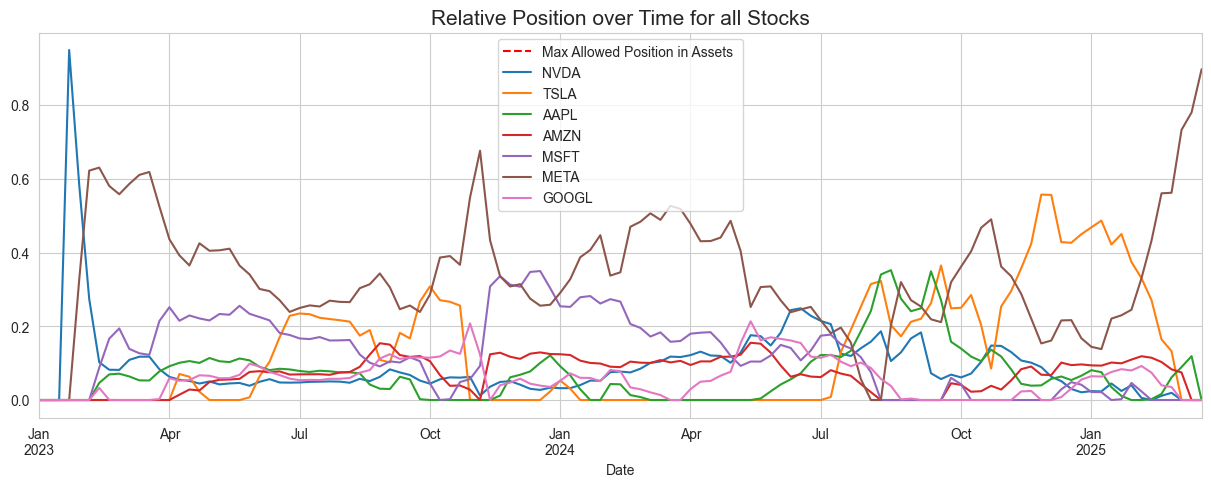

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hlines(y=0.9, xmin=backtest.position_history.index[0],
          xmax=backtest.position_history.index[-1], 
          linestyle="--",
            color="red", 
            label="Max Allowed Position in Assets ")

backtest.position_history.plot(ax=ax)

plt.title("Relative Position over Time for all Stocks", fontsize=15)
ax.legend()
plt.show()

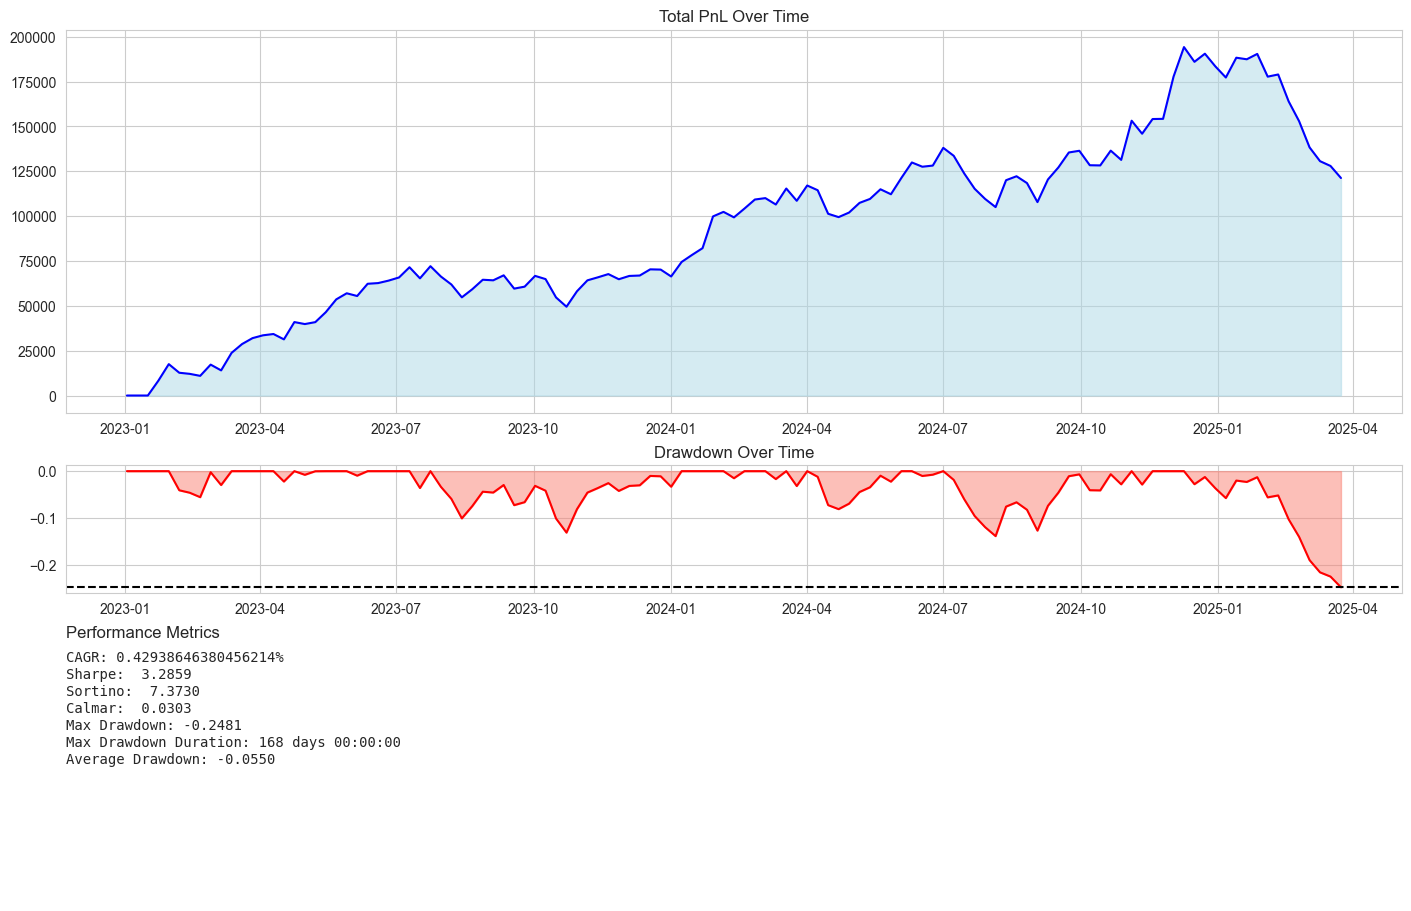

In [9]:
results.performance_dashboard()